## Fisher Linear Discriminant Analysis 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [31]:
def generate_GMM_samples(prior,number_of_samples=400,sig1=[[1,0],[0,1]],sig2=[[1,0],[0,1]],u1=[0,0],u2=[3,3]):
    '''
    Args:
    prior : prior of class 1. (prior of class 2 = 1 - prior (automatically))
    number_of_samples
    
    class 1- u_1, sig_1
    class 2- u_2, sig_2
    
    x is samples from zero-mean identity-covariance Gaussian sample generators

    generating class 1- A1*x+b1
    generating class 2- A2*x+b2
    
    First, the sampled data from gaussians is visualized. 
    Second, the mean and variannce of the gaussians are estimated
    Third, we use Fisher LDA to find the eigenvectors with greatest variance, project the data on to that variance, 
    and find the threshold such that the error (misclassification) is minimized

    '''
    
    # Generate and plot initial samples
    
    samples_class1=[]
    samples_class2=[]
    sig_1=np.matrix(sig1)
    sig_2=np.matrix(sig2)
    u_1=np.matrix(u1).transpose()
    u_2=np.matrix(u2).transpose()
    A1=np.linalg.cholesky(sig_1)
    b1=u_1

    A2=np.linalg.cholesky(sig_2)
    b2=u_2

    zero_mean=[0,0]
    cov=[[1,0],[0,1]]
    for i in range(number_of_samples):
        uniform_sample=np.random.uniform()
        sample_from_zero_mean_identity_covariance=np.random.multivariate_normal(zero_mean,cov,[1]).transpose()

        if uniform_sample<prior:
            '''sample from class 1class 1'''
            sample=A1.dot(sample_from_zero_mean_identity_covariance)+b1
            samples_class1.append(sample)
        else:
            sample=A2.dot(sample_from_zero_mean_identity_covariance)+b2
            samples_class2.append(sample)
    samples_class1_final=np.hstack(samples_class1)
    samples_class2_final=np.hstack(samples_class2)
    a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
    b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

    c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
    d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))
    from matplotlib.pyplot import figure
    figure(figsize=(10, 8))
    plt.scatter(b,a,label='1st gaussian')
    plt.scatter(d,c,label='2nd gaussian')
    plt.title('Plot of samples drawn from two 2D gaussians',fontsize=15)
    plt.xlabel('x1',fontsize=12)
    plt.ylabel('x2',fontsize=12)
    plt.legend()
    #plt.show()


    # Estimate mean and variance of the samples
    sig1=np.cov(samples_class1_final)
    sig2=np.cov(samples_class1_final)
    u1=np.mean(samples_class1_final,axis=1)
    u2=np.mean(samples_class2_final,axis=1)
    sig_1=np.matrix(sig1)
    sig_2=np.matrix(sig2)
    u_1=np.matrix(u1)#.transpose()
    u_2=np.matrix(u2)#.transpose()
    
    
    # Fisher LDA math to find eigenvectors. Plot the original samples along eigenvector axes
    
    Sw=sig_1+sig_2
    Sb=np.matmul((u_1-u_2),((u_1-u_2).transpose()))
    main_matrix=np.matmul((np.linalg.inv(Sw)),Sb)
    #plt.show()
    print (Sw,"\n",Sb,"\n",main_matrix,"\n")
    a,b=np.linalg.eig(main_matrix)
    '''
    a(0) is always smaller 
    '''
    print (a,b)
    if a[0]>a[1]:
        a[0],a[1]=a[1],a[0]
        tmp=b[:,0].copy()
        b[:,0]=b[:,1].copy()
        b[:,1]=tmp.copy()
        
    # Plot the original samples along eigenvector axes
    figure(figsize=(10, 8))
    d=(np.asarray(b)*samples_class1_final).transpose()
    plt.scatter(np.squeeze(np.asarray(d[:,0])),np.squeeze(np.asarray(d[:,1])),label='1st gaussian')
    
    d=(np.asarray(b)*samples_class2_final).transpose()
    plt.scatter(np.squeeze(np.asarray(d[:,0])),np.squeeze(np.asarray(d[:,1])),label='2nd gaussian')
    plt.title('Samples drawn from two 2D gaussians, projected on to their eigenvector axis',fontsize=15)
    plt.xlabel('x1',fontsize=12)
    plt.ylabel('x2',fontsize=12)
    plt.legend()
    #plt.show()
    
    
    # Fisher 1D projection
    
    d1=(np.asarray(b)*samples_class1_final).transpose()
    figure(figsize=(10, 8))
    plt.scatter(np.squeeze(np.asarray(d1[:,0])),np.zeros(len(np.squeeze(np.asarray(d1[:,0])))),label='1st gaussian')

    d2=(np.asarray(b)*samples_class2_final).transpose()
    #figure(figsize=(8, 6))
    plt.scatter(np.squeeze(np.asarray(d2[:,0])),np.zeros(len(np.squeeze(np.asarray(d2[:,0])))),label='2nd gaussian')
    plt.title('Fisher LDA projection of the 2 gaussian distributions',fontsize=15)
    plt.xlabel('x1',fontsize=12)
    plt.ylabel('x2',fontsize=12)
    plt.legend()
    figure(figsize=(10, 8))
    plt.show()
    #figure(figsize=(10, 8))
    
    
    # Calculate and plot misclassification for different thresholds

    error_dict={}
    for threshold in np.linspace(-6,3,50):
        error=0
        for sample in np.squeeze(np.asarray(d1[:,0])):
            if sample<threshold:
                error=error+1
        for sample in np.squeeze(np.asarray(d2[:,0])):
            if sample>threshold:
                error=error+1
        error_dict[threshold]=error
    figure(figsize=(10, 8))
    for keys in error_dict:
        plt.scatter(keys,error_dict[keys])
    plt.title('Plot of misclassification vs Fisher LDA threshold',fontsize=15)
    plt.xlabel('Fisher LDA threshold',fontsize=12)
    plt.ylabel('Misclassification',fontsize=12)
    #plt.legend()

[[ 2.16267552 -0.05539911]
 [-0.05539911  1.92830728]] 
 [[9.01388627 9.07644971]
 [9.07644971 9.13944738]] 
 [[4.2916645  4.32145201]
 [4.83024888 4.86377459]] 

[8.88178420e-16 9.15543909e+00] [[-0.70954799 -0.66420042]
 [ 0.70465712 -0.74755455]]


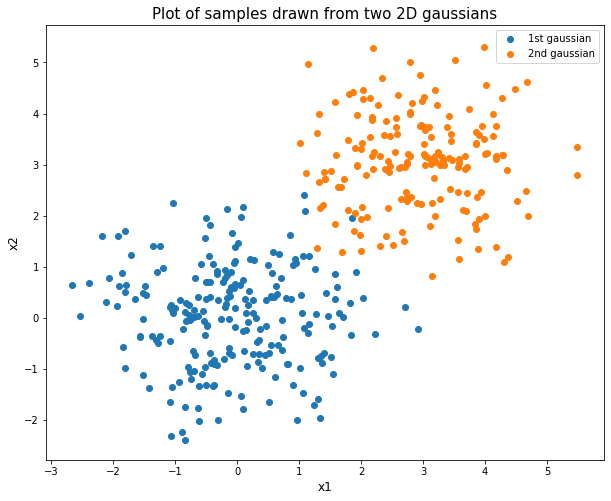

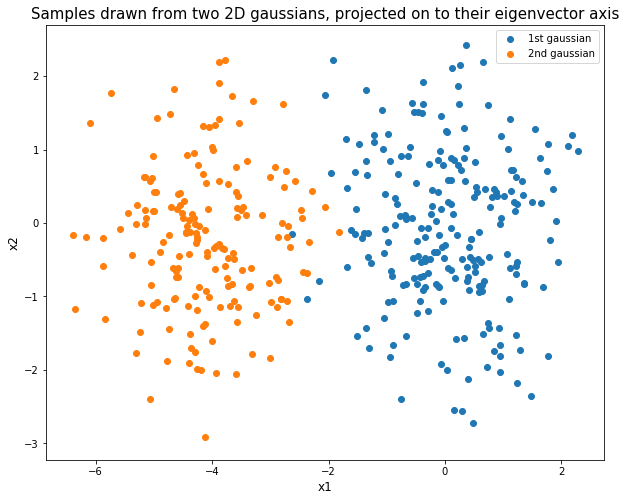

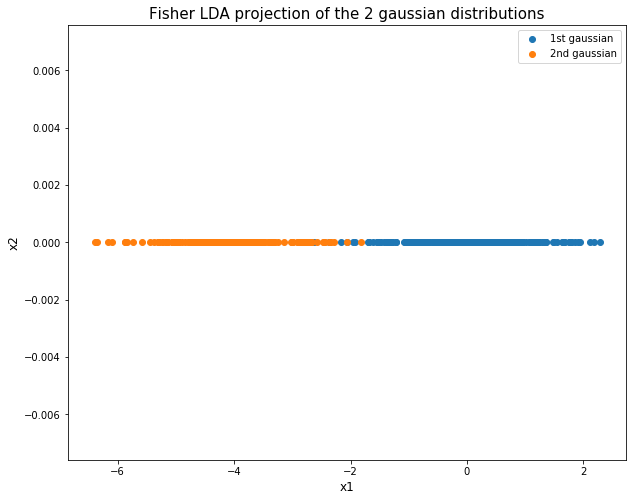

<Figure size 720x576 with 0 Axes>

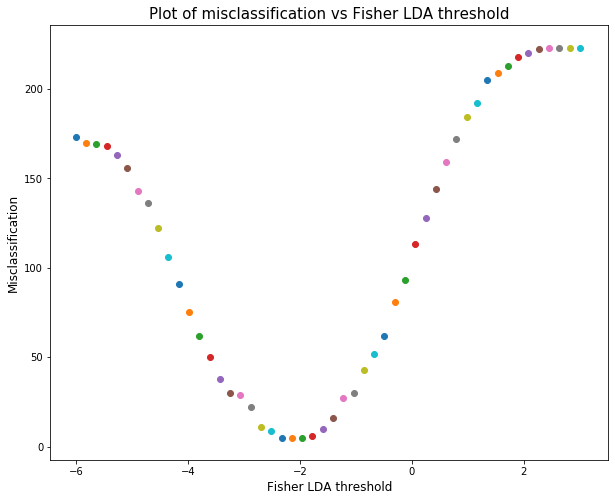

In [32]:
generate_GMM_samples(prior=0.5,number_of_samples=400,sig1=[[1,0],[0,1]],sig2=[[1,0],[0,1]],u1=[0,0],u2=[3,3])

[[5.40764334 2.09048616]
 [2.09048616 1.75132162]] 
 [[9.17933777 9.11021946]
 [9.11021946 9.0416216 ]] 
 [[-0.58207603 -0.57769313]
 [ 5.89671322  5.85231232]] 

[0.         5.27023629] [[-0.70442951  0.0982345 ]
 [ 0.70977395 -0.99516329]]


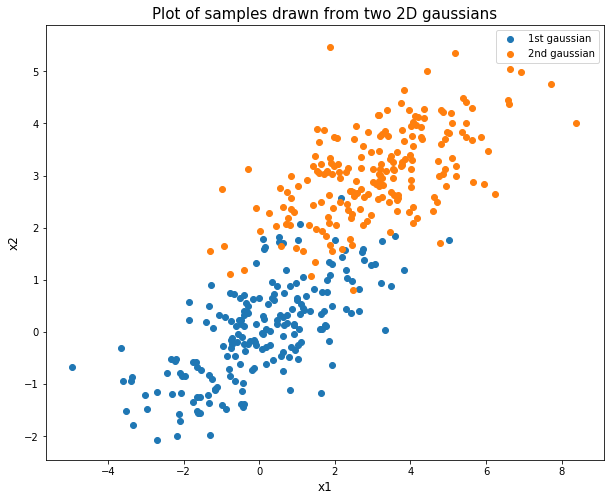

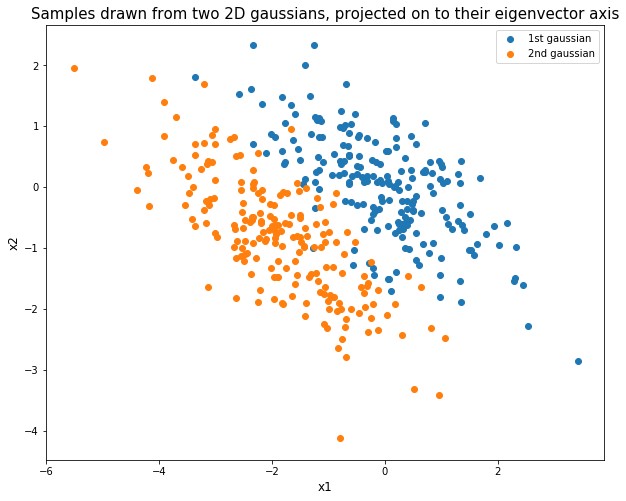

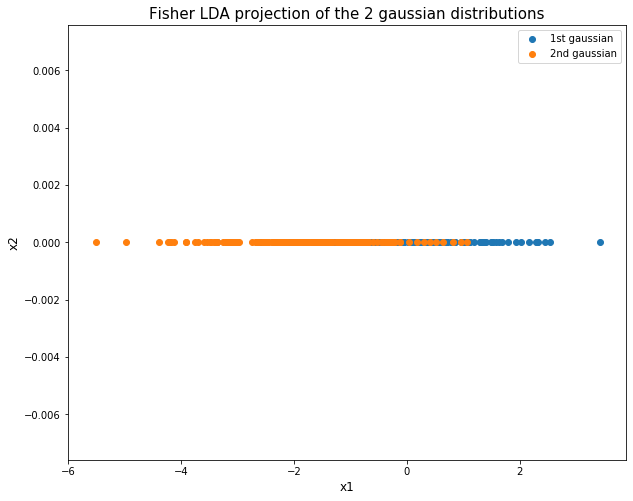

<Figure size 720x576 with 0 Axes>

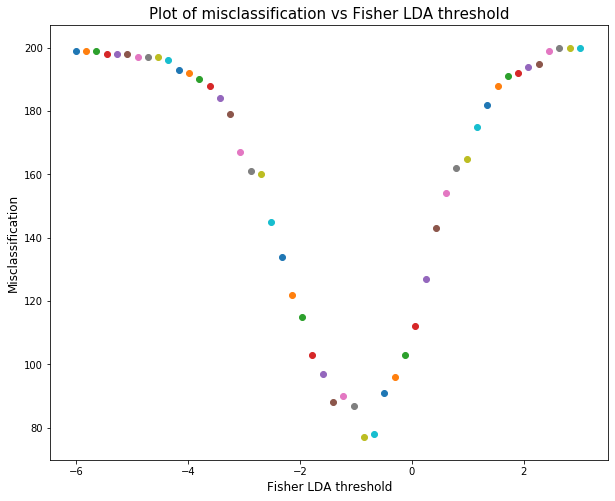

In [36]:
generate_GMM_samples(prior=0.5,number_of_samples=400,sig1=[[3,1],[1,0.8]],sig2=[[3,1],[1,0.8]],u1=[0,0],u2=[3,3])

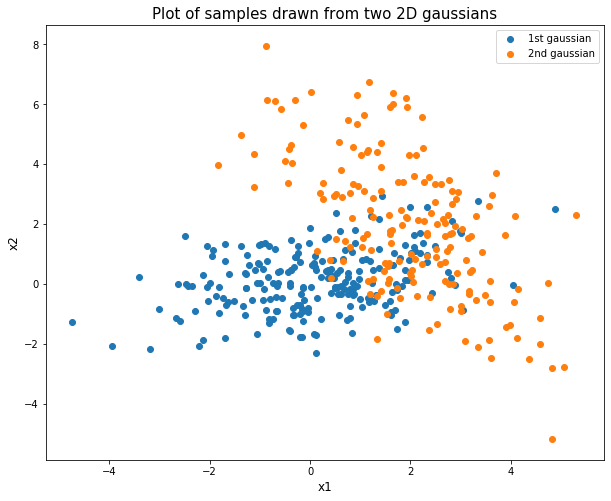

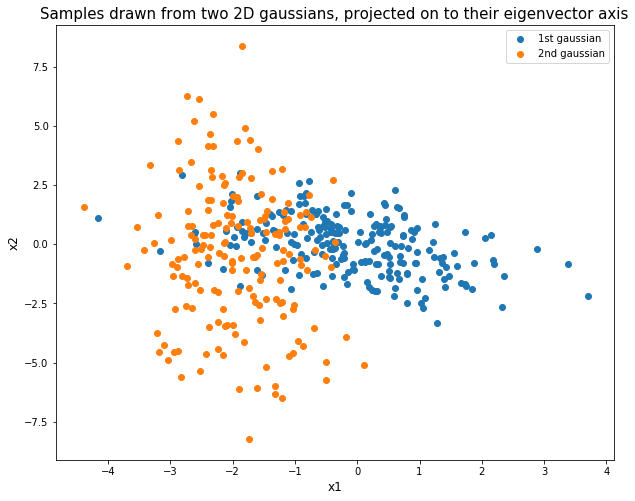

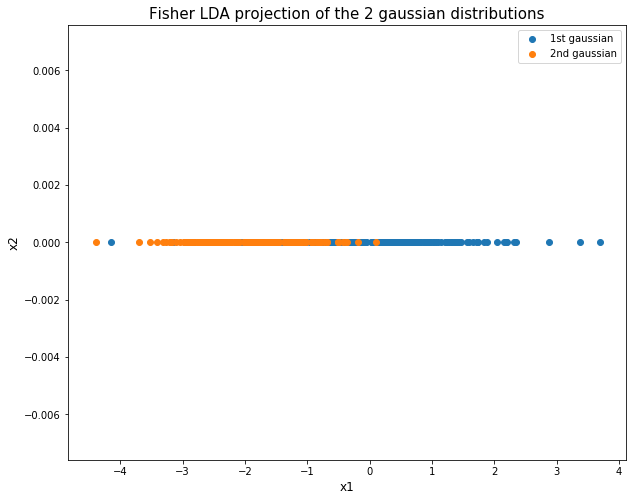

<Figure size 720x576 with 0 Axes>

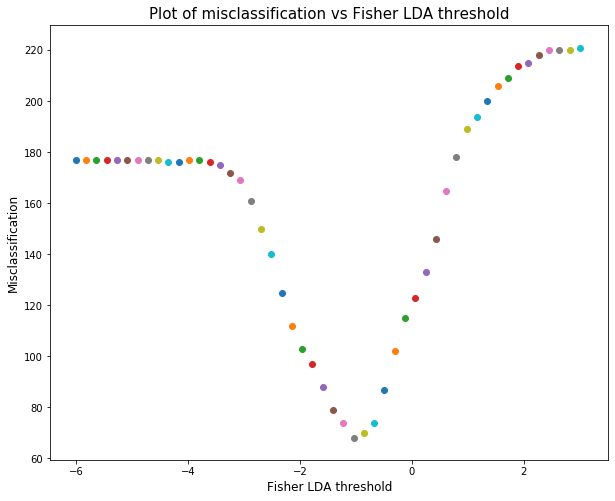

In [12]:
generate_GMM_samples(prior=0.5,number_of_samples=400,sig1=[[2,0.5],[0.5,1]],sig2=[[2,-1.9],[-1.9,5]],u1=[0,0],u2=[2,2])

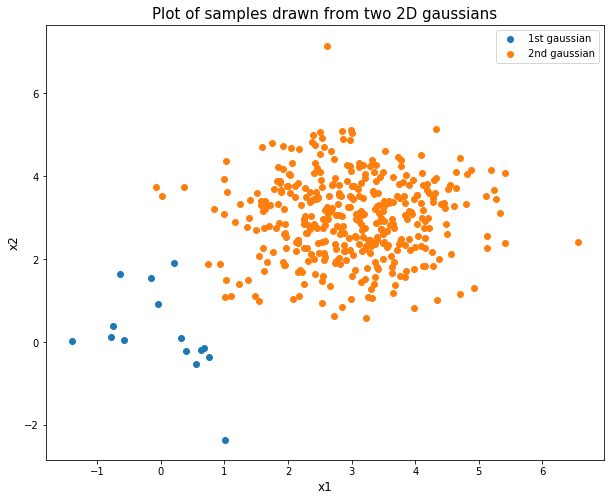

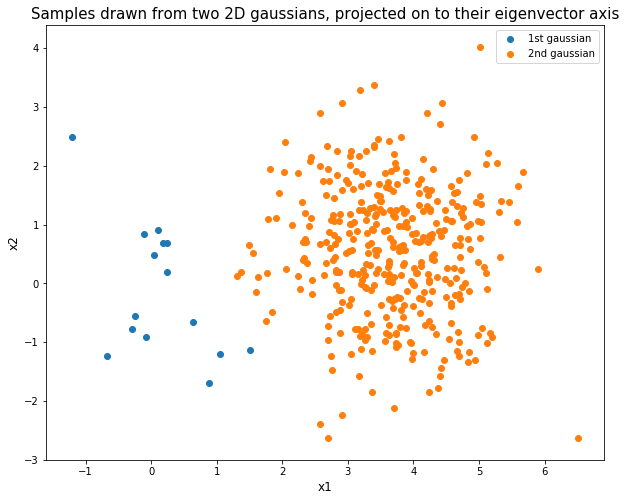

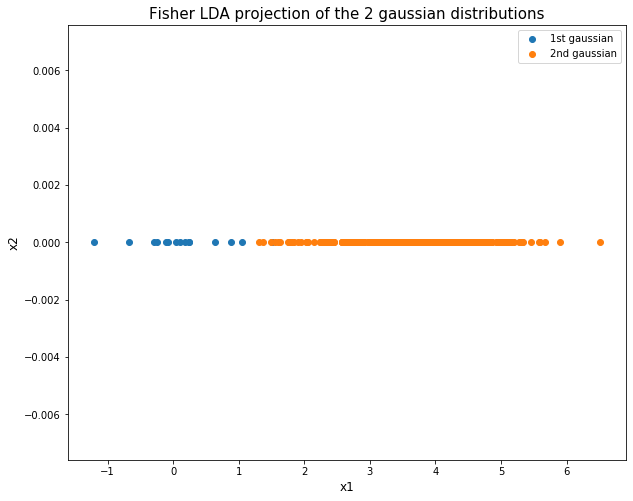

<Figure size 720x576 with 0 Axes>

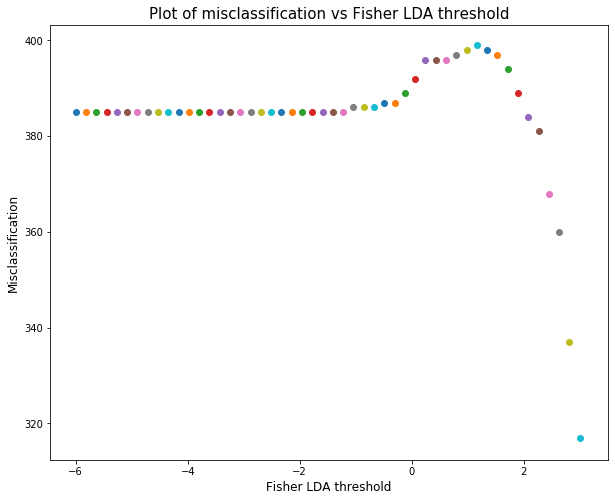

In [14]:
generate_GMM_samples(prior=0.05,number_of_samples=400,sig1=[[1,0],[0,1]],sig2=[[1,0],[0,1]],u1=[0,0],u2=[3,3])

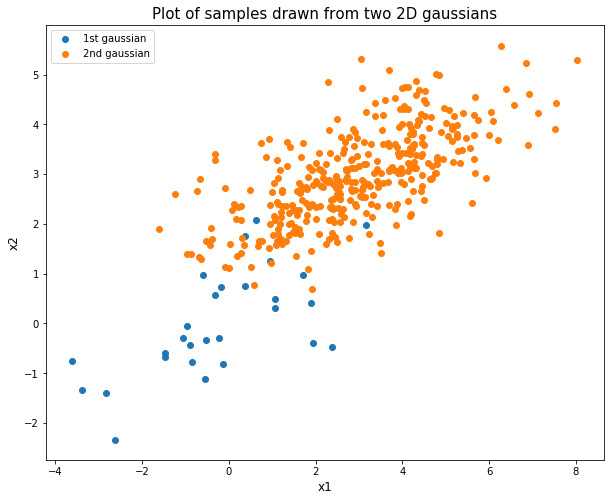

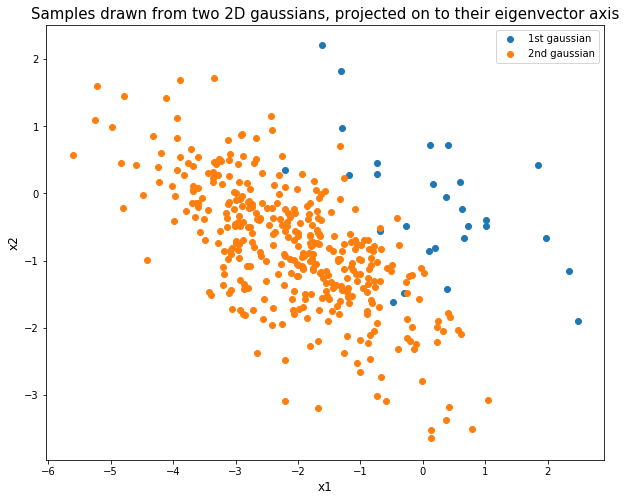

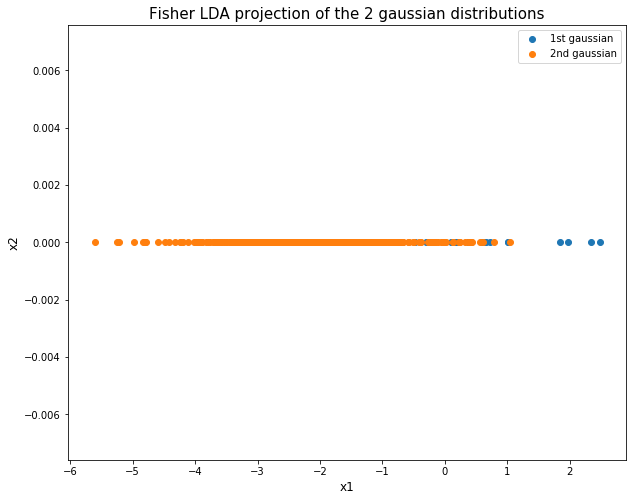

<Figure size 720x576 with 0 Axes>

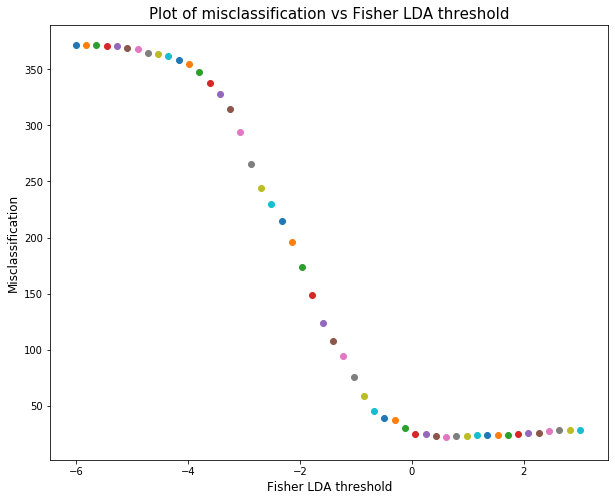

In [15]:
generate_GMM_samples(prior=0.05,number_of_samples=400,sig1=[[3,1],[1,0.8]],sig2=[[3,1],[1,0.8]],u1=[0,0],u2=[3,3])

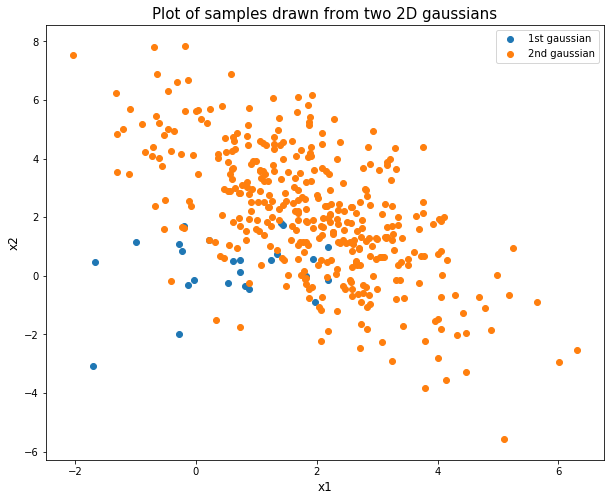

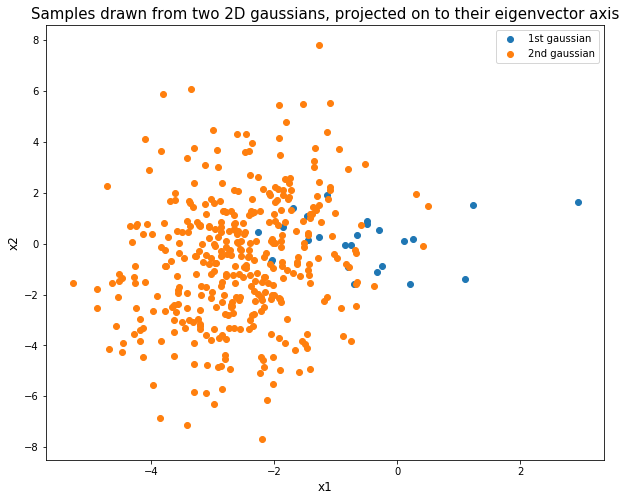

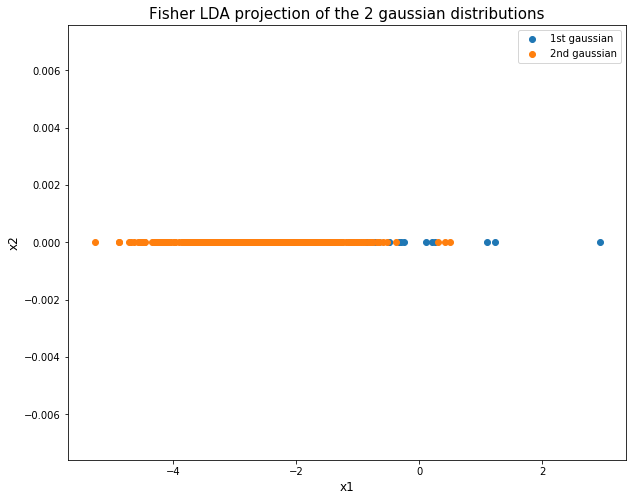

<Figure size 720x576 with 0 Axes>

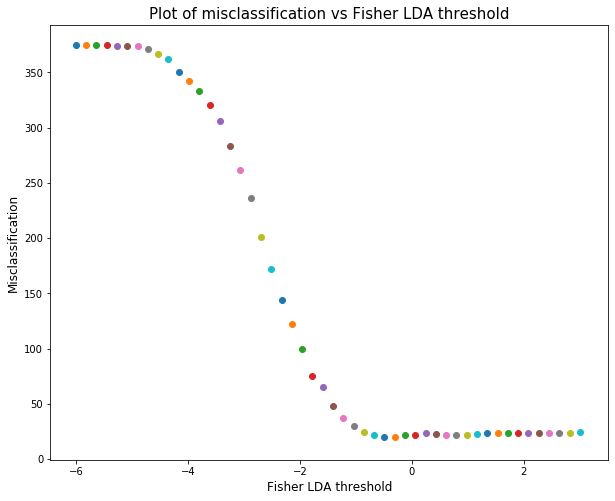

In [16]:
generate_GMM_samples(prior=0.05,number_of_samples=400,sig1=[[2,0.5],[0.5,1]],sig2=[[2,-1.9],[-1.9,5]],u1=[0,0],u2=[2,2])

[[6.7575 2.2881]
 [2.2881 1.7045]] 
 [[8.9174, 8.7234], [8.7234, 8.5337]] 
 [[-0.75767742 -0.74122293]
 [ 6.1349614   6.00157946]] 

[2.15145815e-05 5.24388052e+00] [[-0.69929209  0.12257378]
 [ 0.71483605 -0.9924594 ]]


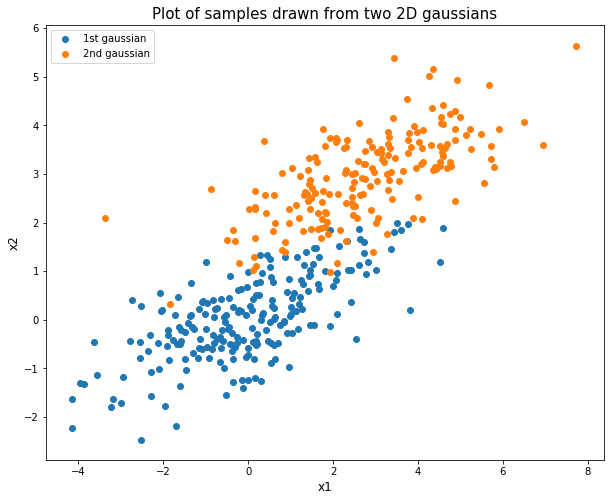

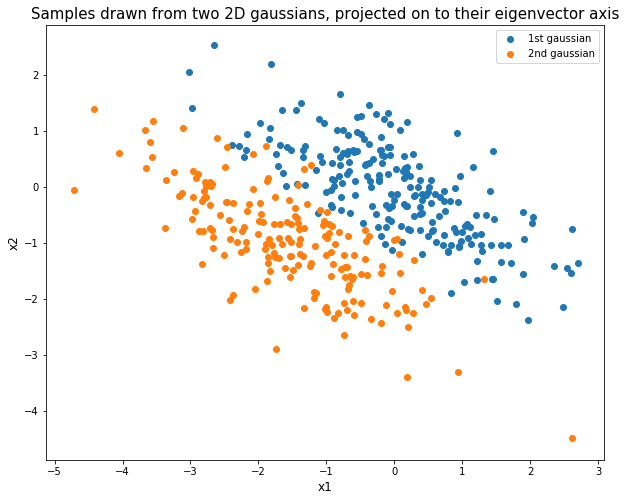

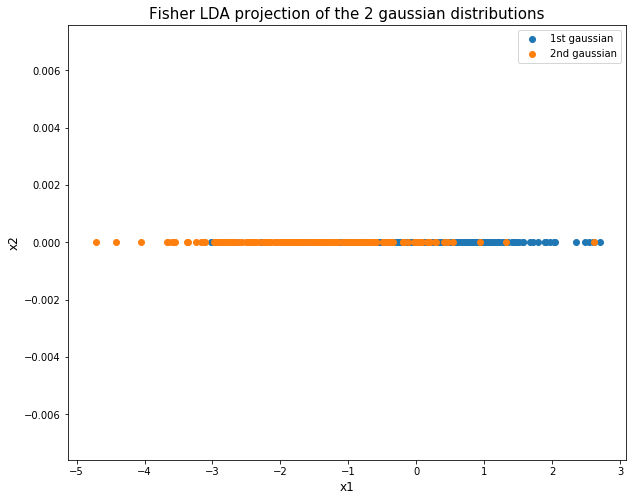

<Figure size 720x576 with 0 Axes>

Text(0, 0.5, 'Misclassification')

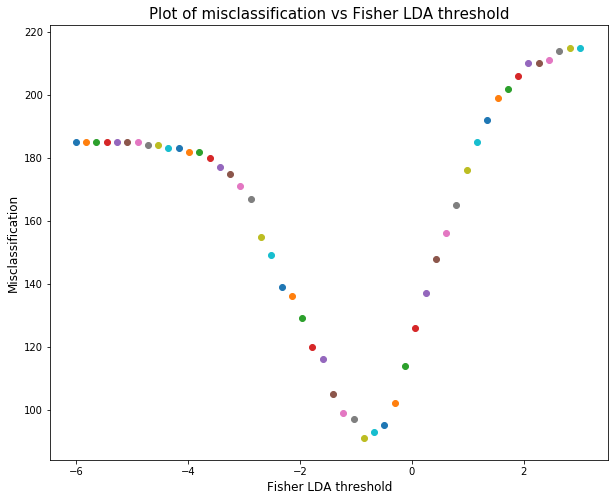

In [21]:
prior=0.5
number_of_samples=400
sig1=[[3,1],[1,0.8]]
sig2=[[3,1],[1,0.8]]
u1=[0,0]
u2=[3,3]

# Generate and plot initial samples

samples_class1=[]
samples_class2=[]
sig_1=np.matrix(sig1)
sig_2=np.matrix(sig2)
u_1=np.matrix(u1).transpose()
u_2=np.matrix(u2).transpose()
A1=np.linalg.cholesky(sig_1)
b1=u_1

A2=np.linalg.cholesky(sig_2)
b2=u_2

zero_mean=[0,0]
cov=[[1,0],[0,1]]
for i in range(number_of_samples):
    uniform_sample=np.random.uniform()
    sample_from_zero_mean_identity_covariance=np.random.multivariate_normal(zero_mean,cov,[1]).transpose()

    if uniform_sample<prior:
        '''sample from class 1class 1'''
        sample=A1.dot(sample_from_zero_mean_identity_covariance)+b1
        samples_class1.append(sample)
    else:
        sample=A2.dot(sample_from_zero_mean_identity_covariance)+b2
        samples_class2.append(sample)
samples_class1_final=np.hstack(samples_class1)
samples_class2_final=np.hstack(samples_class2)
a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
plt.scatter(b,a,label='1st gaussian')
plt.scatter(d,c,label='2nd gaussian')
plt.title('Plot of samples drawn from two 2D gaussians',fontsize=15)
plt.xlabel('x1',fontsize=12)
plt.ylabel('x2',fontsize=12)
plt.legend()
#plt.show()


# Estimate mean and variance of the samples
sig1=np.cov(samples_class1_final)
sig2=np.cov(samples_class1_final)
u1=np.mean(samples_class1_final,axis=1)
u2=np.mean(samples_class2_final,axis=1)
sig_1=np.matrix(sig1)
sig_2=np.matrix(sig2)
u_1=np.matrix(u1)#.transpose()
u_2=np.matrix(u2)#.transpose()


# Fisher LDA math to find eigenvectors. Plot the original samples along eigenvector axes

Sw=sig_1+sig_2
Sb=np.matmul((u_1-u_2),((u_1-u_2).transpose()))


Sw=np.array([[6.7575,2.2881],[2.2881,1.7045]])
Sb=[[8.9174,8.7234],[8.7234,8.5337]]
main_matrix=np.matmul((np.linalg.inv(Sw)),Sb)
#plt.show()
print (Sw,"\n",Sb,"\n",main_matrix,"\n")
a,b=np.linalg.eig(main_matrix)
'''
a(0) is always smaller 
'''
print (a,b)
if a[0]>a[1]:
    a[0],a[1]=a[1],a[0]
    tmp=b[:,0].copy()
    b[:,0]=b[:,1].copy()
    b[:,1]=tmp.copy()
    
# Plot the original samples along eigenvector axes
figure(figsize=(10, 8))
d=(np.asarray(b)*samples_class1_final).transpose()
plt.scatter(np.squeeze(np.asarray(d[:,0])),np.squeeze(np.asarray(d[:,1])),label='1st gaussian')

d=(np.asarray(b)*samples_class2_final).transpose()
plt.scatter(np.squeeze(np.asarray(d[:,0])),np.squeeze(np.asarray(d[:,1])),label='2nd gaussian')
plt.title('Samples drawn from two 2D gaussians, projected on to their eigenvector axis',fontsize=15)
plt.xlabel('x1',fontsize=12)
plt.ylabel('x2',fontsize=12)
plt.legend()
#plt.show()


# Fisher 1D projection

d1=(np.asarray(b)*samples_class1_final).transpose()
figure(figsize=(10, 8))
plt.scatter(np.squeeze(np.asarray(d1[:,0])),np.zeros(len(np.squeeze(np.asarray(d1[:,0])))),label='1st gaussian')

d2=(np.asarray(b)*samples_class2_final).transpose()
#figure(figsize=(8, 6))
plt.scatter(np.squeeze(np.asarray(d2[:,0])),np.zeros(len(np.squeeze(np.asarray(d2[:,0])))),label='2nd gaussian')
plt.title('Fisher LDA projection of the 2 gaussian distributions',fontsize=15)
plt.xlabel('x1',fontsize=12)
plt.ylabel('x2',fontsize=12)
plt.legend()
figure(figsize=(10, 8))
plt.show()
#figure(figsize=(10, 8))


# Calculate and plot misclassification for different thresholds

error_dict={}
for threshold in np.linspace(-6,3,50):
    error=0
    for sample in np.squeeze(np.asarray(d1[:,0])):
        if sample<threshold:
            error=error+1
    for sample in np.squeeze(np.asarray(d2[:,0])):
        if sample>threshold:
            error=error+1
    error_dict[threshold]=error
figure(figsize=(10, 8))
for keys in error_dict:
    plt.scatter(keys,error_dict[keys])
plt.title('Plot of misclassification vs Fisher LDA threshold',fontsize=15)
plt.xlabel('Fisher LDA threshold',fontsize=12)
plt.ylabel('Misclassification',fontsize=12)
#plt.legend()

In [22]:
Sw=np.array([[6.7575,2.2881],[2.2881,1.7045]])
Sb=[[8.9174,8.7234],[8.7234,8.5337]]
main_matrix=np.matmul((np.linalg.inv(Sw)),Sb)
a,b=np.linalg.eig(main_matrix)
b

array([[-0.69929209,  0.12257378],
       [ 0.71483605, -0.9924594 ]])

In [23]:
a

array([2.15145815e-05, 5.24388052e+00])

In [27]:
b[:,0]

array([-0.69929209,  0.71483605])

In [28]:
b[:,1]

array([ 0.12257378, -0.9924594 ])

In [26]:
np.linalg.eig?